# Practice for 5511 CNN 
### Cancer Detection Kaggle Mini-Project

*May 2023*



### **Problem Statement**

The main objective of this project is to develop a deep learning model that can detect cancer in histopathologic scans of lymph nodes. Specifically, the model will be designed to identify metastatic tissues in these scans, which will assist in the diagnosis and treatment of cancer in patients. Instead of relying solely on human interpretation of these scans for diagnosis, the model will provide a more accurate and efficient way to detect cancerous tissues, potentially improving patient outcomes.



### **Data Source:**

https://www.kaggle.com/competitions/histopathologic-cancer-detection/data


The data set includes 220025 images for training, each image has a label of 0 or 1 in 'train_labels.csv', and also 57458 test images to be labeled.




### **Methodology**

To classify test images with the right label, we will use cnn. After implementing this approach, we will upload the label of test images to kaggle to see the accuracy.

By completing this project, we hope to enhance our knowledge of cnn and its applicability in real-world scenarios.


### **Detail steps** 


**1. Exploratory Data Analysis (EDA)** 

Firstly we will explore and visualize the data to understand the structure and distribution of the data.  

**2. Model Training & Evaluation**

Next, we will build cnn with training data set and check the performance on test dataset. 

**3. Conclusions**

Finally, we will summarize the results and see what can be improved in the future. 

In [8]:
# importing the necessary libraries:
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import random
from PIL import Image

#  EDA

#### DATA LOADING

In [2]:
train_all = pd.read_csv("./data/train_labels.csv")
train_all.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


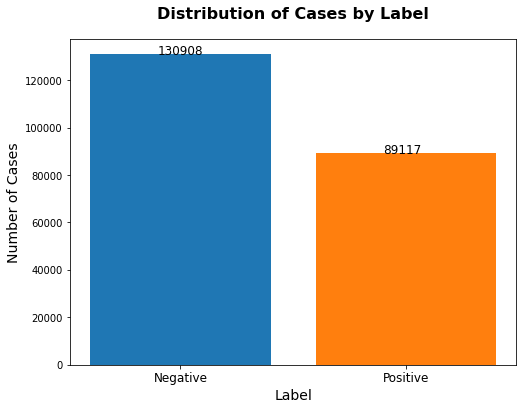

In [11]:
# Count the cases by label
cases_by_label = train_all['label'].value_counts()

plt.figure(figsize=(8,6)) # Set the figure size
plt.bar(cases_by_label.index, cases_by_label.values, color=['tab:blue', 'tab:orange'])
plt.title('Distribution of Cases by Label', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.xticks(cases_by_label.index, ['Negative', 'Positive'], fontsize=12)

for i, v in enumerate(cases_by_label.values):
    plt.text(i-0.1, v+50, str(v), color='black', fontsize=12)

plt.show()

## Observations:

* There are no missing labels in training data set.
* In the training dataset, the ratio of positive cases to negative cases is 60:40, it's quite balanced, so we don't need to take additional actions to balance the data.

define some constants

In [3]:
# dimensions of our images
img_width, img_height = 96, 96

train_data_dir = './data/train/'
test_data_dir = './data/test/'

# hyperparameters
epochs = 30
batch_size = 32
lr = 0.0001
es_patience = 5
rlr_patience = 3
rlr_factor = 0.1

./data/train/cee3483ec4912044bc0fd160bbc481033f827176.tif 0
./data/train/315829e49ae8790237b16fa6b3ba84fc07792844.tif 0
./data/train/0fcb6db83cc993d84f120d121f783d4b975b2167.tif 0
./data/train/e72055df27700ec8f2493f92863f7958653c4b8c.tif 0
./data/train/9a99cd89545cb8a9e5530d2cb61e900d34c9a28c.tif 0
./data/train/d52408c68fbf7af8708ac7b6efe569af5dc0bfbd.tif 0
./data/train/88703b23c02ef475d21fb8e44cc673745fc3de71.tif 0
./data/train/7360407a64fc531e8f418f195ab3ecf63d070bf6.tif 0
./data/train/f5a7520435702ca613099b6e62dbaae15f8b1323.tif 0
./data/train/2bba2ed16bd846831be30764df562460e90db89a.tif 0
./data/train/1b392f200f5829750bd5bffacb0b9b5bf2d79bcb.tif 0
./data/train/050acfe7acc73e1b87195e364e46d0eb399a3923.tif 0
./data/train/3227583953b4fb49bb59a8f7519c106af5180225.tif 0
./data/train/6b8da5dd4eb13216ef7f31f062bca50abac57c47.tif 0
./data/train/f63c9633c3dfc07d4c2c814456b39fe9a2321f0d.tif 0
./data/train/ffafde731445587a7bdb0459704a5487813ee299.tif 0
./data/train/1c8c05b6819876ce552f4330739

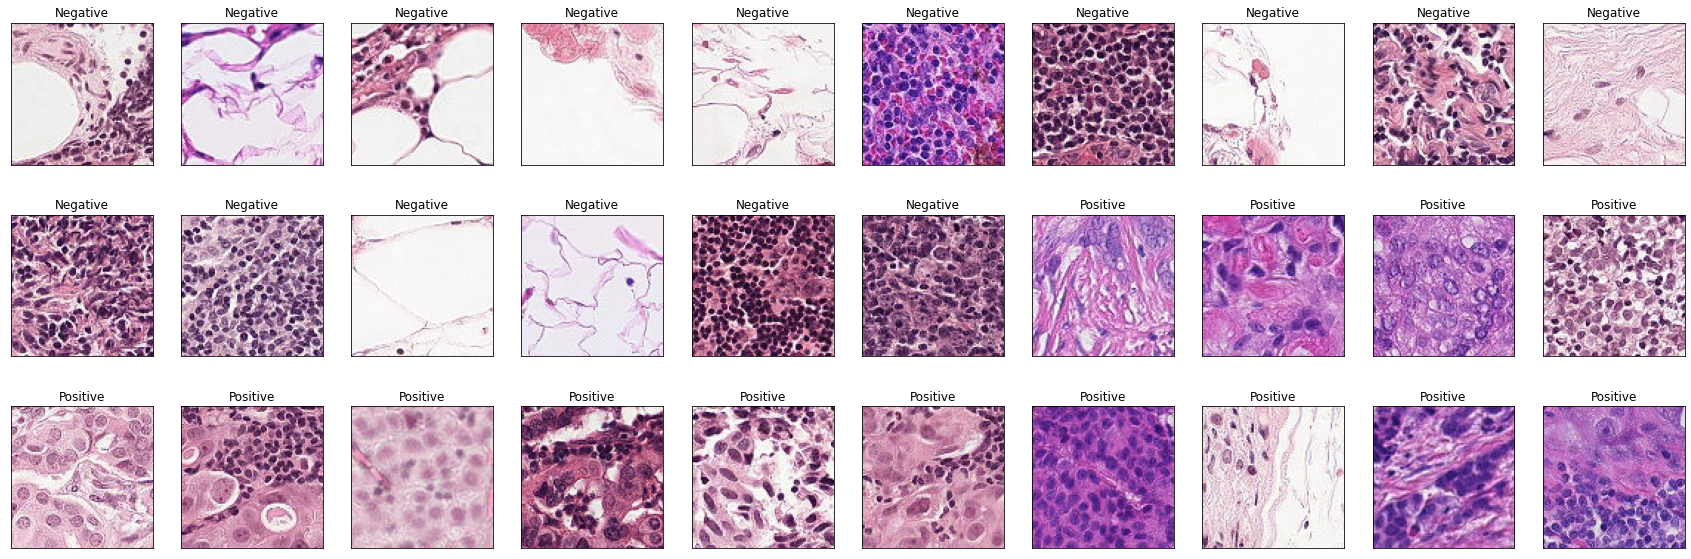

In [9]:
# Randomly check 30 images

ids = random.sample(range(len(train_all)), 30)
sel = train_all.loc[ids, ['id', 'label']].sort_values('label')

k = 1
fig = plt.figure(figsize=(30, 10))
for index, row in sel.iterrows():
    imgname = row['id']
    lb = row['label']
    print(train_data_dir + imgname + '.tif', lb)
    ax = fig.add_subplot(3,30//3, k, xticks=[], yticks=[])
    img = Image.open(train_data_dir + imgname + '.tif')
    plt.imshow(img)
    lab = 'Negative' if lb == 0 else 'Positive'
    ax.set_title(lab)
    k = k + 1



load the training labels into a pandas DataFrame

In [10]:
train_labels_df = pd.read_csv('./data/train_labels.csv')
train_labels_df['id'] = train_labels_df['id'] + ".tif"
train_labels_df['label'] = train_labels_df['label'].astype(str)
train_labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


Split the data into a training set and a validation set, allocating 90% to training and 10% to validation.Split the data into a training set and a validation set, allocating 90% to training and 10% to validation.

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.1
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    directory=train_data_dir,
    x_col='id',
    y_col='label',
    subset='training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    directory=train_data_dir,
    x_col='id',
    y_col='label',
    subset='validation',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 198023 validated image filenames belonging to 2 classes.
Found 22002 validated image filenames belonging to 2 classes.


Next, we can define our CNN model, the purpose of each step can be found in the comments

In [ ]:
# define the model as a Sequential object 
model = Sequential()

# add a Conv2D layer with 32 filters, a kernel size of (3,3), same padding, and the input shape of (img_width, img_height, 3)
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3)))
# add an activation function of relu to the layer
model.add(Activation('relu'))
# add a MaxPooling2D layer with a pool size of (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# repeat the same process for another Conv2D layer with 64 filters
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# repeat the same process for another Conv2D layer with 128 filters
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# repeat the same process for another Conv2D layer with 256 filters
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add a Flatten layer to flatten the output from the previous layers
model.add(Flatten())
# add a Dense layer with 256 units/neurons
model.add(Dense(256))
# add an activation function of relu to the layer
model.add(Activation('relu'))
# add a Dropout layer with a rate of 0.5
model.add(Dropout(0.5))
# add another Dense layer with 1 unit/neuron for binary classification
model.add(Dense(1))
# add an activation function of sigmoid to the layer
model.add(Activation('sigmoid'))

# compile the model using the binary_crossentropy loss function, RMSprop optimizer with a specified learning rate, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=lr), metrics=['accuracy'])


train the model and make predictions on the testing set

In [6]:
# define callbacks
early_stopping = EarlyStopping(patience=es_patience, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=rlr_factor, patience=rlr_patience, min_lr=0.000001, verbose=1)

# train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

In [11]:
# Save the model
model.save('model_1.h5')

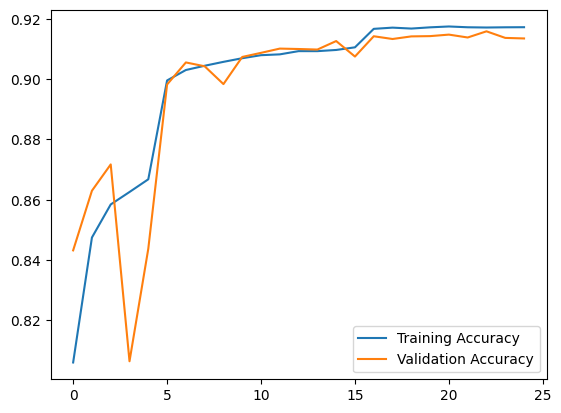

In [7]:
# Plot the training and validation loss and accuracy

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()

In [24]:
# Evaluate the model
scores = model.evaluate(train_generator)
print("Accuracy: %.2f%%" % (scores[1]*100))

6189/6189 [==============================] - 1174s 190ms/step - loss: 0.2268 - accuracy: 0.9171
Accuracy: 91.71%


In [ ]:
# Evaluate the model on the validation set, 
# load the training dataset with shuffle=False to make sure the predicted label and actual on the same record

valid_generator2 = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    directory=train_data_dir,
    x_col='id',
    y_col='label',
    subset='validation',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

AUC: 0.9681057769275763


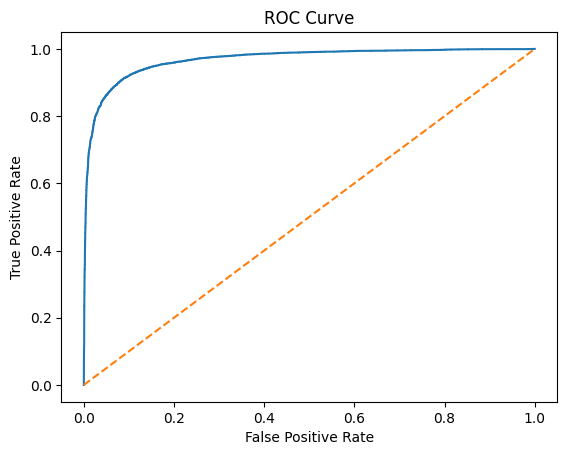

In [29]:
# make a prediction on validation set
y_prob_valid = model.predict(valid_generator2)

y_pred_valid = (y_prob_valid > 0.5).astype(int)

accuracy = accuracy_score(valid_generator2.classes, y_pred_valid)
print("Accuracy:", accuracy)

fpr, tpr, thresholds_keras = roc_curve(valid_generator2.classes, y_prob_valid)
auc_keras = auc(fpr, tpr)
print("AUC:", auc_keras)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### Observation: The AUC is 0.968, which is pretty good.

## To apply the model on test data set 

### Load test data

In [15]:
# Get the list of file names in the folder
file_names = os.listdir(test_data_dir)

# Create a dictionary with the file names as keys and empty lists as values
dict_files = {'id': file_names}

# Convert the dictionary to a dataframe
df_test = pd.DataFrame(dict_files)

# Display the dataframe
df_test.head()

,id
0,00006537328c33e284c973d7b39d340809f7271b.tif
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,000270442cc15af719583a8172c87cd2bd9c7746.tif


In [17]:
# create data generator for testing set
test_datagen = ImageDataGenerator(rescale=1./255)

# test dataset is not necessary to be shuffled
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_data_dir,
    x_col='id',
    y_col=None,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [18]:
# make predictions on testing set
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predictions = predictions.ravel()

# create submission DataFrame
submission_df = pd.DataFrame({
    'id': [f.split('/')[-1] for f in test_generator.filenames],
    'label': predictions
})

submission_df['id'] = submission_df['id'].str[:-4]

# create submission file, and save the probability of positive case in column label
submission_df.to_csv('submission.csv', index=False)

1796/1796 [==============================] - 599s 334ms/step


In [19]:
submission_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,9.998026e-01
1,0000ec92553fda4ce39889f9226ace43cae3364e,9.816446e-01
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,9.991837e-01
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,2.371815e-14
4,000270442cc15af719583a8172c87cd2bd9c7746,2.274353e-02


In [28]:
# set the cutoff at 0.5 to classify each case
submission_df['label'] = [1 if x >= 0.5 else 0 for x in submission_df['label']]

# create submission file, and save 0 or 1 for each case in column label
submission_df.to_csv('submission2.csv', index=False)

In [31]:
# final try

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
# adds a 2D convolutional layer with first_filters filters, 
# a kernel_size of 3x3, a ReLU activation function, 
# and an input shape of 3 channels (RGB) and size IMAGE_SIZE.
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (img_width, img_height, 3)))

# This adds a second convolutional layer with first_filters filters, 
# a kernel_size of 3x3, and no activation function. 
# A BatchNormalization layer is added for regularization, 
# followed by a ReLU activation function, 
# a MaxPooling layer with pool_size of 2x2, 
# and a dropout layer with a rate of dropout_conv.
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))


# This adds another pair of convolutional layers, 
# with second_filters filters and a kernel_size of 3x3. 
# BatchNormalization and ReLU activation functions are added between them, 
# and a MaxPooling layer and a dropout layer with the same rate as the previous one follow.
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))


# This adds a third pair of convolutional layers, 
# with third_filters filters and a kernel_size of 3x3. 
# BatchNormalization and ReLU activation functions are added between them, 
# and a MaxPooling layer and a dropout layer with the same rate as the previous ones follow.
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))


# This flattens the output of the convolutional and pooling layers, 
# then adds a dense layer with 256 units, 
# followed by BatchNormalization, ReLU activation, 
# and a dropout layer. Finally, 
# a single output unit with a sigmoid activation function is added.
#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(th())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=lr), metrics=['accuracy'])

# define callbacks
early_stopping = EarlyStopping(patience=es_patience, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=rlr_factor, patience=rlr_patience, min_lr=0.000001, verbose=1)

# train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


2023-05-20 00:09:31.451628: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6188/6188 [==============================] - 1436s 232ms/step - loss: 0.4228 - accuracy: 0.8167 - val_loss: 0.3976 - val_accuracy: 0.8394 - lr: 1.0000e-04
Epoch 2/30
6188/6188 [==============================] - 1431s 231ms/step - loss: 0.3393 - accuracy: 0.8580 - val_loss: 0.3367 - val_accuracy: 0.8511 - lr: 1.0000e-04
Epoch 3/30
6188/6188 [==============================] - 1468s 237ms/step - loss: 0.2978 - accuracy: 0.8794 - val_loss: 0.4208 - val_accuracy: 0.8422 - lr: 1.0000e-04
Epoch 4/30
6188/6188 [==============================] - 1122s 181ms/step - loss: 0.2720 - accuracy: 0.8919 - val_loss: 0.3943 - val_accuracy: 0.8515 - lr: 1.0000e-04
Epoch 5/30
6188/6188 [==============================] - 1107s 179ms/step - loss: 0.2558 - accuracy: 0.8997 - val_loss: 0.3048 - val_accuracy: 0.8621 - lr: 1.0000e-04
Epoch 6/30
6188/6188 [==============================] - 1196s 193ms/step - loss: 0.2431 - accuracy: 0.9054 - val_loss: 0.4424 - val_accuracy: 0.8375 - lr: 1.0000e-04
Epoch 7/30
6188

688/688 [==============================] - 112s 163ms/step
Accuracy: 0.939960003636033
AUC: 0.9828646230935683


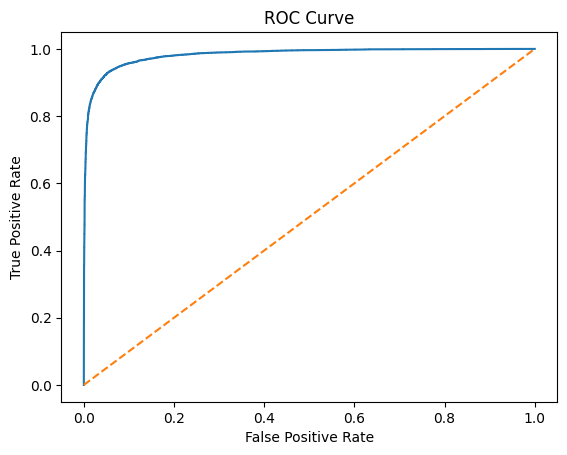

In [32]:
# make a prediction on validation set
y_prob_valid = model.predict(valid_generator2)

y_pred_valid = (y_prob_valid > 0.5).astype(int)

accuracy = accuracy_score(valid_generator2.classes, y_pred_valid)
print("Accuracy:", accuracy)

fpr, tpr, thresholds_keras = roc_curve(valid_generator2.classes, y_prob_valid)
auc_keras = auc(fpr, tpr)
print("AUC:", auc_keras)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### Observation: The AUC improved from original 0.968 to 0.982

In [37]:
# make predictions on testing set
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predictions = predictions.ravel()

# create submission DataFrame
submission_df = pd.DataFrame({
    'id': [f.split('/')[-1] for f in test_generator.filenames],
    'label': predictions
})

submission_df['id'] = submission_df['id'].str[:-4]

1796/1796 [==============================] - 285s 158ms/step


In [38]:
submission_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.991385
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.764751
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.972920
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.717088
4,000270442cc15af719583a8172c87cd2bd9c7746,0.008822


In [39]:
# save submission file
submission_df.to_csv('submission_full_sample_additional_steps.csv', index=False)

In [40]:
submission_df['label'] = [1 if x >= 0.5 else 0 for x in submission_df['label']]
# save submission file
submission_df.to_csv('submission_full_sample_additional_steps_int.csv', index=False)

______ 
# Result
______

As seen above, after testing various models, I found that the last one I tried had an accuracy of 0.93996 and an AUC of 0.982 on the validation set.

To evaluate the model's performance on the test dataset, I uploaded my solution outputs to Kaggle. You may notice that the first score I received (the bottom one) was only 0.5 because I had forgotten to set 'shuffle = False' when loading the test data initially. Once I reloaded the test data with 'shuffle = False' and made some other clean-ups and added additional layers to the model, the highest private score I received was 0.8901, which still fell short of the top players though.

Also, there was a gap between my public score and private score, which indicates that there is still an overfitting issue. So for the next step, I plan to take more decisive steps to mitigate the overfitting issue.



![alt text](kaggle_score_cnn.png "Solution Score") 